In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop2.7"

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

## Загрузите данные при помощи spark.read.csv из приложенного файла

In [16]:
spdf = spark.read.csv("iris.CSV", header=True, inferSchema=True)

In [17]:
spdf.show()

+------------+-----------+------------+-----------+-------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|variety|variety_num|
+------------+-----------+------------+-----------+-------+-----------+
|         5.1|        3.5|         1.4|        0.2| Setosa|          0|
|         4.9|        3.0|         1.4|        0.2| Setosa|          0|
|         4.7|        3.2|         1.3|        0.2| Setosa|          0|
|         4.6|        3.1|         1.5|        0.2| Setosa|          0|
|         5.0|        3.6|         1.4|        0.2| Setosa|          0|
|         5.4|        3.9|         1.7|        0.4| Setosa|          0|
|         4.6|        3.4|         1.4|        0.3| Setosa|          0|
|         5.0|        3.4|         1.5|        0.2| Setosa|          0|
|         4.4|        2.9|         1.4|        0.2| Setosa|          0|
|         4.9|        3.1|         1.5|        0.1| Setosa|          0|
|         5.4|        3.7|         1.5|        0.2| Setosa|     

## Воспользуйтесь командами groupBy, max, min и avg, чтобы вывести максимальное минимальное и среднее значние каждого из аттрбутов цветка ('sepal_length','sepal_width','petal_length','petal_width')

In [19]:
spdf_grouped = spdf.groupBy('variety').max('sepal_length','sepal_width','petal_length','petal_width')
spdf_grouped.show()

+----------+-----------------+----------------+-----------------+----------------+
|   variety|max(sepal_length)|max(sepal_width)|max(petal_length)|max(petal_width)|
+----------+-----------------+----------------+-----------------+----------------+
| Virginica|              7.9|             3.8|              6.9|             2.5|
|    Setosa|              5.8|             4.4|              1.9|             0.6|
|Versicolor|              7.0|             3.4|              5.1|             1.8|
+----------+-----------------+----------------+-----------------+----------------+



In [21]:
spdf_grouped = spdf.groupBy('variety').min('sepal_length','sepal_width','petal_length','petal_width')
spdf_grouped.show()

+----------+-----------------+----------------+-----------------+----------------+
|   variety|min(sepal_length)|min(sepal_width)|min(petal_length)|min(petal_width)|
+----------+-----------------+----------------+-----------------+----------------+
| Virginica|              4.9|             2.2|              4.5|             1.4|
|    Setosa|              4.3|             2.3|              1.0|             0.1|
|Versicolor|              4.9|             2.0|              3.0|             1.0|
+----------+-----------------+----------------+-----------------+----------------+



In [22]:
spdf_grouped = spdf.groupBy('variety').avg('sepal_length','sepal_width','petal_length','petal_width')
spdf_grouped.show()

+----------+-----------------+------------------+------------------+------------------+
|   variety|avg(sepal_length)|  avg(sepal_width)| avg(petal_length)|  avg(petal_width)|
+----------+-----------------+------------------+------------------+------------------+
| Virginica|6.587999999999998|2.9739999999999998|             5.552|             2.026|
|    Setosa|5.005999999999999| 3.428000000000001|1.4620000000000002|0.2459999999999999|
|Versicolor|            5.936|2.7700000000000005|              4.26|1.3259999999999998|
+----------+-----------------+------------------+------------------+------------------+



In [23]:
import matplotlib.pyplot as plt

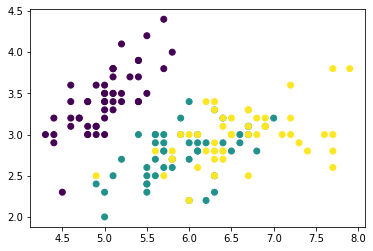

In [ ]:
plt.scatter(spdf[['sepal_length']].collect(), spdf[['sepal_width']].collect(), c=spdf[['variety_num']].collect())

## Выведите по аналогии график petal_length и petal_width, так же раскрашенный по типам цветков

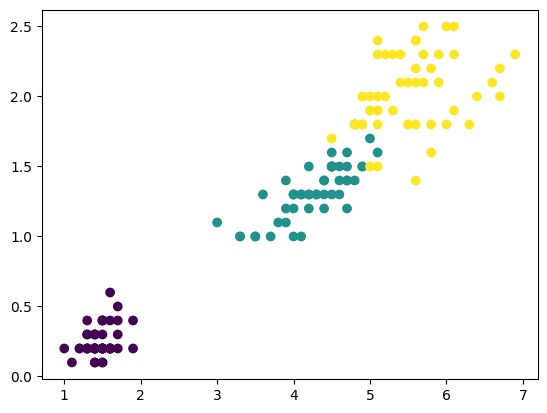

In [25]:
plt.scatter(spdf[['petal_length']].collect(), spdf[['petal_width']].collect(), c=spdf[['variety_num']].collect())

## Посмотрите внимательно на получившийся график и сформируйте правило вида ЕСЛИ ЗНАЧЕНИЕ ПАРАМЕТРА A < ЗНАЧЕНИЕ, ТО IRIS ОТНОСИТСЯ К КЛАССУ SETOSA - ИНАЧЕ К КАКОМУ-ТО ДРУГОМУ (НАЗОВЕМ, ЕГО НАПРИМЕР UNKNOWN)


`if petal_length < 2,5 / petal_width < 0.75 then iris is setosa otherwise unknown`

## При помощи команд withColumn, when, otherwise создайте в датафрейме новую колонку с таким предсказанием

In [27]:
from pyspark.sql.functions import when

In [33]:
spdf_wpred = spdf.withColumn("Prediction", col= when(spdf['petal_length']<2.5, 'Setosa').otherwise('Unknown'))

In [35]:
spdf_wpred.show(5)

+------------+-----------+------------+-----------+-------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|variety|variety_num|Prediction|
+------------+-----------+------------+-----------+-------+-----------+----------+
|         5.1|        3.5|         1.4|        0.2| Setosa|          0|    Setosa|
|         4.9|        3.0|         1.4|        0.2| Setosa|          0|    Setosa|
|         4.7|        3.2|         1.3|        0.2| Setosa|          0|    Setosa|
|         4.6|        3.1|         1.5|        0.2| Setosa|          0|    Setosa|
|         5.0|        3.6|         1.4|        0.2| Setosa|          0|    Setosa|
+------------+-----------+------------+-----------+-------+-----------+----------+
only showing top 5 rows



## Проверьте качество своего предсказания
Для этого:
1. Подсчитайте количество строк, где Вы предсказали класс Setosa и правильный класс был так же Setosa
2. Подсчитайте количество строк, где Вы предскзали класс Setosa, а правильный класс был какой-то другой (воспользуйтесь оператором "не равно" - !=)

In [36]:
spdf_wpred.where(spdf_wpred['variety'] == 'Setosa').count()

50

In [38]:
spdf_wpred.where((spdf_wpred['variety'] == 'Setosa') & (spdf_wpred['variety'] != spdf_wpred['Prediction'])).count()

0